In [2]:
import argparse
import os, sys
from utils.data_utils import *
from glob import glob
import pandas as pd
import numpy as np
import shutil
from tqdm import tqdm
%matplotlib inline  
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [12,9]

from keras.models import Input, Model, Sequential
from keras.layers import Dense
from keras.regularizers import l1, l2, l1_l2
from keras.callbacks import LambdaCallback
from sklearn.model_selection import StratifiedKFold, train_test_split

np.set_printoptions(precision=5)
np.set_printoptions(suppress=True)

Using TensorFlow backend.


In [3]:
def is_windows():
    return sys.platform == 'win32'

res_dir = os.path.join('predictions')
if is_windows():
    l_dirs = ['0.21', '0.22', '0.23', '0.24', '0.25']
else:
    l_dirs = ['0.09']
    
def get_data_dir(a, t):
    if t:
        if a:
            data_dir = 'train_ex'
        else:
            data_dir = 'train'
    else:
        if a:
            data_dir = 'valid_ex'
        else:
            data_dir = 'valid'
    return data_dir

def load_loss_df(l_dirs, augmented=False, train=False):
    data_dir = get_data_dir(augmented, train)
    dataframes = []
    for d in l_dirs:
        dataframes.append(pd.read_csv(os.path.join(res_dir, data_dir, d, 'models.csv')))

    df_l = pd.concat(dataframes, ignore_index=True)
    return df_l

def get_gt_name(a, t):
    if t:
        if a:
            name = 'Y_train_augmented.npz'
        else:
            name = 'Y_train.npz'
    else:
        if a:
            name = 'Y_valid_augmented.npz'
        else:
            name = 'Y_valid.npz'
    return name

def load_ground_truth(data_dir, augmented=False, train=False):
    gt_name = get_gt_name(augmented, train)
    y_true_path = os.path.join('augmented', data_dir, gt_name)
    y_true = npz_to_ndarray(np.load(y_true_path))
    return y_true

def load_preds(df_loss, transposed=False):
    preds = []
    for npz_path in df_loss.res_path:
        p = npz_to_ndarray(np.load(npz_path))
        if transposed:
            preds.append(p.transpose())
        else:
            preds.append(p)
    return np.array(preds)

In [4]:
valid_augmented = True

In [5]:
df_loss_valid = load_loss_df(l_dirs, augmented=valid_augmented, train=False)
print(len(df_loss_valid))

76


In [6]:
preds_valid = load_preds(df_loss_valid, transposed=True)
print(preds_valid.shape)

(76, 17, 64768)


In [7]:
y_true_valid = load_ground_truth('train_augmented_size_128_mult_8_seed_0', augmented=valid_augmented, train=False)
print(y_true_valid.shape)

(64768, 17)


In [8]:
def get_ensemble_avg_score(ensemble, all_preds, y_true, opt_th=False, opt_step=0.05, th=0.2):
    ensemble_preds = [all_preds[j] for j in ensemble]
    avg_pred = np.mean(ensemble_preds, axis=0)
    if not opt_th:
        avg_pred_final = (avg_pred > th).astype(int)
    else:
        thresholds = find_ratios(y_true, avg_pred, step=opt_step)
        avg_pred_final = (avg_pred > thresholds).astype(int)
    avg_score = fbeta_score(y_true, avg_pred_final, beta=2, average='samples')
    return avg_score

def opt_thresholds(ensemble, all_preds, y_true, opt_step=0.05):
    ensemble_preds = [all_preds[j] for j in ensemble]
    avg_pred = np.mean(ensemble_preds, axis=0)
    thresholds = find_ratios(y_true, avg_pred, step=opt_step)
    avg_pred_final = (avg_pred > thresholds).astype(int)
    avg_score = fbeta_score(y_true, avg_pred_final, beta=2, average='samples')
    return np.array(thresholds), avg_score

In [9]:
# ensemble = [20, 62]
# ensemble = [20, 62, 13, 46, 8]
ensemble = [20, 62, 13, 46, 8, 22, 12, 51, 25]

In [10]:
preds_valid_ensemble = np.array([preds_valid[j] for j in ensemble])
print("%s" % str(preds_valid_ensemble.shape))
dim_batch_valid = preds_valid_ensemble.shape[2]
dim_classes = preds_valid_ensemble.shape[1]
dim_models = preds_valid_ensemble.shape[0]

(9, 17, 64768)


In [11]:
X_valid = preds_valid_ensemble.transpose().reshape((dim_batch_valid, dim_classes*dim_models))
# X_valid = (X_valid > 0.2).astype(int)
Y_valid = y_true_valid
print("%s, %s" % (X_valid.shape, Y_valid.shape))

(64768, 153), (64768, 17)


In [12]:
# X_t, X_v, Y_t, Y_v = train_test_split(X_valid, Y_valid, test_size=0.2, random_state=0)

In [13]:
def create_model():
    inp = Input(batch_shape=(None, dim_classes*dim_models))
    x = Dense(17, activation='sigmoid')(inp)
    model = Model(inputs=inp, outputs=x)
#     model.summary()
    return model

In [17]:
epochs = 100
splits = 5
scores = []
def my_callback_func(batch, logs):
    p = (model.predict(X_valid[test]) > 0.2).astype(int)
    score = fbeta_score(Y_valid[test], p, beta=2, average='samples')
    scores.append(score)


kfold = StratifiedKFold(n_splits=splits, shuffle=False, random_state=0)
cvscores = []
counter = 0
for train, test in kfold.split(X_valid,Y_valid[:,0]):
    print("\nItteration %d" % counter)
    model = create_model()
    model.compile(loss='mse', optimizer='nadam', metrics=['accuracy'])
    my_callback = LambdaCallback(on_epoch_end=lambda batch, logs: my_callback_func(batch, logs))
    model.fit(X_valid[train], Y_valid[train], epochs=epochs, batch_size=128, verbose=2, \
              validation_data=(X_valid[test], Y_valid[test]), callbacks=[my_callback])
    # evaluate the model
    pred_v_final = (model.predict(X_valid[test]) > 0.2).astype(int)
    score = fbeta_score(Y_valid[test], pred_v_final, beta=2, average='samples')

    print("It %d: CV score %.5f" % (counter, score))
    cvscores.append(score)
    counter+=1
    
print("\nAverage cross validation score %.5f\n" % np.mean(cvscores))
print(np.array(cvscores))


Itteration 0
Train on 51814 samples, validate on 12954 samples
Epoch 1/100
2s - loss: 0.0484 - acc: 0.3153 - val_loss: 0.0286 - val_acc: 0.3793
Epoch 2/100
2s - loss: 0.0275 - acc: 0.4022 - val_loss: 0.0270 - val_acc: 0.3888
Epoch 3/100
2s - loss: 0.0266 - acc: 0.4141 - val_loss: 0.0264 - val_acc: 0.4588
Epoch 4/100
2s - loss: 0.0263 - acc: 0.4131 - val_loss: 0.0262 - val_acc: 0.4548
Epoch 5/100
2s - loss: 0.0261 - acc: 0.4502 - val_loss: 0.0260 - val_acc: 0.3806
Epoch 6/100
2s - loss: 0.0259 - acc: 0.4501 - val_loss: 0.0259 - val_acc: 0.4092
Epoch 7/100
1s - loss: 0.0258 - acc: 0.4681 - val_loss: 0.0258 - val_acc: 0.4216
Epoch 8/100
2s - loss: 0.0257 - acc: 0.4411 - val_loss: 0.0258 - val_acc: 0.4081
Epoch 9/100
1s - loss: 0.0257 - acc: 0.4516 - val_loss: 0.0257 - val_acc: 0.4057
Epoch 10/100
2s - loss: 0.0256 - acc: 0.4343 - val_loss: 0.0256 - val_acc: 0.4155
Epoch 11/100
1s - loss: 0.0255 - acc: 0.4066 - val_loss: 0.0256 - val_acc: 0.4088
Epoch 12/100
1s - loss: 0.0255 - acc: 0.402

KeyboardInterrupt: 

In [78]:
epochs = 150
splits = 5
scores = []
def my_callback_func(batch, logs):
    p = (model.predict(X_valid[test]) > 0.2).astype(int)
    score = fbeta_score(Y_valid[test], p, beta=2, average='samples')
    scores.append(score)


kfold = StratifiedKFold(n_splits=splits, shuffle=False, random_state=0)
cvscores = []
counter = 0
for train, test in kfold.split(X_valid,Y_valid[:,0]):
    print("\nItteration %d" % counter)
    model = create_model()
    model.compile(loss='mse', optimizer='nadam', metrics=['accuracy'])
    my_callback = LambdaCallback(on_epoch_end=lambda batch, logs: my_callback_func(batch, logs))
    model.fit(X_valid[train], Y_valid[train], epochs=epochs, batch_size=128, verbose=2, \
              validation_data=(X_valid[test], Y_valid[test]), callbacks=[my_callback])
    # evaluate the model
    pred_v_final = (model.predict(X_valid[test]) > 0.2).astype(int)
    score = fbeta_score(Y_valid[test], pred_v_final, beta=2, average='samples')

    print("It %d: CV score %.5f" % (counter, score))
    cvscores.append(score)
    counter+=1
    
print("\nAverage cross validation score %.5f\n" % np.mean(cvscores))
print(np.array(cvscores))


Itteration 0
Train on 51814 samples, validate on 12954 samples
Epoch 1/150
3s - loss: 0.0473 - acc: 0.2935 - val_loss: 0.0276 - val_acc: 0.3590
Epoch 2/150
2s - loss: 0.0262 - acc: 0.3992 - val_loss: 0.0256 - val_acc: 0.3875
Epoch 3/150
2s - loss: 0.0251 - acc: 0.3992 - val_loss: 0.0250 - val_acc: 0.3833
Epoch 4/150
2s - loss: 0.0248 - acc: 0.3954 - val_loss: 0.0248 - val_acc: 0.3655
Epoch 5/150
2s - loss: 0.0246 - acc: 0.3773 - val_loss: 0.0246 - val_acc: 0.3890
Epoch 6/150
2s - loss: 0.0245 - acc: 0.3778 - val_loss: 0.0246 - val_acc: 0.3627
Epoch 7/150
2s - loss: 0.0244 - acc: 0.3659 - val_loss: 0.0244 - val_acc: 0.3712
Epoch 8/150
2s - loss: 0.0243 - acc: 0.3630 - val_loss: 0.0244 - val_acc: 0.3192
Epoch 9/150
2s - loss: 0.0242 - acc: 0.3482 - val_loss: 0.0243 - val_acc: 0.3553
Epoch 10/150
2s - loss: 0.0242 - acc: 0.3430 - val_loss: 0.0243 - val_acc: 0.3204
Epoch 11/150
2s - loss: 0.0241 - acc: 0.3349 - val_loss: 0.0242 - val_acc: 0.3231
Epoch 12/150
2s - loss: 0.0241 - acc: 0.328

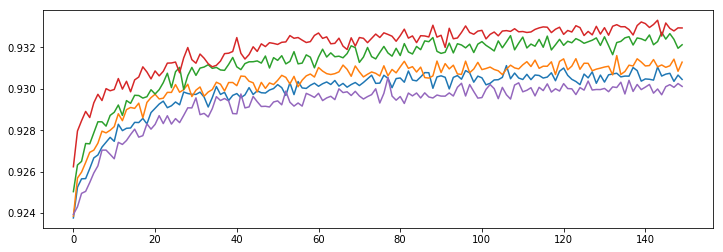

In [79]:
scores = np.array(scores).reshape((splits,epochs))
plt.figure(figsize=(12, 4))
for i in range(len(scores)):
    plt.plot(scores[i])

In [ ]:
model = create_model()
model.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['accuracy'])
history_callback = model.fit(X_valid, Y_valid, batch_size=128, epochs=50, verbose=2)

p = (model.predict(X_valid) > 0.2).astype(int)
s = fbeta_score(Y_valid, p, beta=2, average='samples')
print("Validation score %.5f" % s)
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_callback.history['loss'])

Epoch 1/50
5s - loss: 0.1592 - acc: 0.9537
Epoch 2/50
2s - loss: 0.0949 - acc: 0.9674
Epoch 3/50
2s - loss: 0.0914 - acc: 0.9677
Epoch 4/50
2s - loss: 0.0902 - acc: 0.9678
Epoch 5/50
2s - loss: 0.0895 - acc: 0.9679
Epoch 6/50
2s - loss: 0.0890 - acc: 0.9680
Epoch 7/50
2s - loss: 0.0886 - acc: 0.9681
Epoch 8/50
2s - loss: 0.0883 - acc: 0.9681
Epoch 9/50
2s - loss: 0.0880 - acc: 0.9682
Epoch 10/50
2s - loss: 0.0877 - acc: 0.9683
Epoch 11/50
2s - loss: 0.0875 - acc: 0.9682
Epoch 12/50
2s - loss: 0.0873 - acc: 0.9683
Epoch 13/50
2s - loss: 0.0871 - acc: 0.9684
Epoch 14/50
2s - loss: 0.0870 - acc: 0.9683
Epoch 15/50
2s - loss: 0.0868 - acc: 0.9684
Epoch 16/50
2s - loss: 0.0867 - acc: 0.9684
Epoch 17/50
2s - loss: 0.0865 - acc: 0.9684
Epoch 18/50
2s - loss: 0.0864 - acc: 0.9684
Epoch 19/50
2s - loss: 0.0863 - acc: 0.9684
Epoch 20/50
2s - loss: 0.0862 - acc: 0.9685
Epoch 21/50
2s - loss: 0.0861 - acc: 0.9685
Epoch 22/50
2s - loss: 0.0860 - acc: 0.9685
Epoch 23/50
2s - loss: 0.0859 - acc: 0.96

In [19]:
df_loss_valid.loc[ensemble]

,model,model_name,loss,epoch,path,score,res_path
20,starter1_11_0.09,starter1,0.09,11,models/starter1_128_binary_crossentropy_rmspro...,0.924217,predictions/valid_ex/0.09/starter1_128_binary_...
62,inception2_41_0.09,inception2,0.09,41,models/inception2_128_binary_crossentropy_rmsp...,0.922441,predictions/valid_ex/0.09/inception2_128_binar...
13,net1_25_0.09,net1,0.09,25,models/net1_128_binary_crossentropy_rmsprop/ne...,0.923863,predictions/valid_ex/0.09/net1_128_binary_cros...
46,best1_24_0.09,best1,0.09,24,models/best1_128_binary_crossentropy_rmsprop/b...,0.923987,predictions/valid_ex/0.09/best1_128_binary_cro...
8,net1_23_0.09,net1,0.09,23,models/net1_128_binary_crossentropy_rmsprop/ne...,0.923349,predictions/valid_ex/0.09/net1_128_binary_cros...
22,starter1_16_0.09,starter1,0.09,16,models/starter1_128_binary_crossentropy_rmspro...,0.920841,predictions/valid_ex/0.09/starter1_128_binary_...
12,net1_24_0.09,net1,0.09,24,models/net1_128_binary_crossentropy_rmsprop/ne...,0.922402,predictions/valid_ex/0.09/net1_128_binary_cros...
51,best1_25_0.09,best1,0.09,25,models/best1_128_binary_crossentropy_rmsprop/b...,0.921921,predictions/valid_ex/0.09/best1_128_binary_cro...
25,starter1_22_0.09,starter1,0.09,22,models/starter1_128_binary_crossentropy_rmspro...,0.922563,predictions/valid_ex/0.09/starter1_128_binary_...


In [21]:
import shutil
ensemble_dir = os.path.join('other_models', 'ensemble19')
if not os.path.exists(ensemble_dir):
    os.makedirs(ensemble_dir)

df_loss_valid.loc[ensemble].to_csv(os.path.join(ensemble_dir, 'ensemble.csv'), index=False)
model.save(os.path.join(ensemble_dir, 'ensemble.h5'))
print("Done")

Done


In [84]:
cls=1
w1=model.get_weights()[0][:,cls].reshape((17,len(ensemble)))
for i in range(17):
    print(w1[i,:])

[-0.38718 -4.34958 -1.13701  4.29419  0.43361 -0.95385  2.39799  6.59623
 -2.06755]
[-0.24695  1.3378   0.04068 -0.13581  0.86781 -1.01024  0.77773 -0.28198
  1.2612 ]
[ 5.43042  1.90878  1.50009 -0.39615  4.75237  0.16414  6.60644 -2.4065
 -9.10934]
[ 1.09006  0.25946  0.07439  0.15213 -0.41977  0.66175 -0.52716  0.82006
 -0.4586 ]
[-0.97793 -1.39469  2.22475 -0.49544 -0.72974 -1.82272 -1.57234 -1.65482
  2.1075 ]
[-3.49954  4.72296 -4.40251 -4.69596  1.37798  1.37423  0.13722 -3.55392
  0.29625]
[ 0.40832  1.61688 -0.74899  0.126    0.55047 -1.24926 -1.09496  0.49176
 -0.07547]
[-0.33052 -0.56736  1.38907 -1.37688 -1.13991 -2.98382 -0.16896  0.7742
  0.18347]
[-0.75892  0.07161  0.39899 -1.51493  0.41124 -0.06153 -0.35169  0.018
  0.96315]
[-1.88379 -0.16795  0.08499 -1.38996  0.41828 -0.3594  -0.98292 -0.87551
  0.22216]
[ 2.66582  0.23568 -1.99911 -0.98645 -1.07646  0.31014 -0.98432  0.33276
 -1.47518]
[ 0.33967 -0.12905  0.02881 -0.47807  1.99835 -0.44999 -0.4384  -1.31547
  0.212

In [24]:
def reconstruct(X_r):
    X_r_reconstructed = np.empty((5,X_r.shape[0],17))
    temp1 = X_r.reshape((X_r.shape[0],17,5)).transpose()
    for i in range(temp1.shape[0]):
        X_r_reconstructed[i] = temp1[i].transpose()
    return X_r_reconstructed

In [132]:
p_v_reconstructed = (np.mean(reconstruct(X_v), axis=0) > 0.2).astype(int)
fbeta_score(Y_v, p_v_reconstructed, beta=2, average='samples')

0.92931595872088246

In [183]:
p_t_reconstructed = (np.mean(reconstruct(X_t), axis=0) > 0.2).astype(int)
fbeta_score(Y_t, p_t_reconstructed, beta=2, average='samples')

0.94096011664754398

In [184]:
p_reconstructed = (np.mean(reconstruct(X), axis=0) > 0.2).astype(int)
fbeta_score(Y, p_reconstructed, beta=2, average='samples')

0.94111441765341974